In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt

In [2]:
# Print the number of available GPUs
num_gpus = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus)

# Get the details of each GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("GPU Name: ", gpu.name)
    print("GPU Details: ", gpu)

Num GPUs Available:  1
GPU Name:  /physical_device:GPU:0
GPU Details:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preparation

In [3]:
DATASET_PATH = "./Eating_Sound_16bit/"

#Train 90%
#Validation 5%
#Test 5%

#Split Train 90% Validation 10%
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATASET_PATH,
    batch_size=64,
    output_sequence_length=16000,
    validation_split=0.1,
    subset="both",
    seed=0
)

#Split Validation 5% Test 5%
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Found 11140 files belonging to 20 classes.
Using 10026 files for training.
Using 1114 files for validation.


In [4]:
#print all labels
label_names = np.array(train_ds.class_names)

print(label_names)

['aloe' 'burger' 'cabbage' 'candied_fruits' 'carrots' 'chips' 'chocolate'
 'drinks' 'fries' 'grapes' 'gummies' 'ice-cream' 'jelly' 'noodles'
 'pickles' 'pizza' 'ribs' 'salmon' 'soup' 'wings']


In [5]:
# Squeeze
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)  # Squeeze to remove the last dimension

    return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
#Convert audio to spectrogram

def get_spectrogram(audio):
    #convert audio ke spectrogram (stft)
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
        
    #ambil nilai absolute
    spectrogram = tf.abs(spectrogram)
    
    #tambahin dimensi
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram

#membuat dataset spectrogram
def make_spectrogram_ds(ds):
    return ds.map(map_func = lambda audio, 
        label: (get_spectrogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE)

#buat variable untuk spectrogram_ds
train_spec_ds = make_spectrogram_ds(train_ds)
val_spec_ds = make_spectrogram_ds(val_ds)
test_spec_ds = make_spectrogram_ds(test_ds)

#optimalisasi dataset (cache, prefetch)
train_spec_ds = train_spec_ds.cache().shuffle(2030).prefetch(tf.data.AUTOTUNE)
val_spec_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spec_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

# CNN Architecture

In [7]:
#ambil batch pertama dari spectrogram
for samples_ds, samples_ds_labels in test_spec_ds.take(1):
    break

input_shape = samples_ds.shape[1:]
num_label = len(label_names)

print(input_shape)
print(num_label)

(124, 129, 1)
20


In [8]:
norm_layer = layers.Normalization()
norm_layer.adapt(
    data = train_spec_ds.map(map_func= lambda spec, label: spec)
)

In [9]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_label, activation="softmax")
])

In [10]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200


c:\Users\chris\miniconda3\envs\gpuconda\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


157/157 [==============================] - 61s 331ms/step - loss: 2.8830 - accuracy: 0.0983 - val_loss: 2.7406 - val_accuracy: 0.1710
Epoch 2/200
157/157 [==============================] - 58s 367ms/step - loss: 2.6704 - accuracy: 0.1696 - val_loss: 2.4961 - val_accuracy: 0.2286
Epoch 3/200
157/157 [==============================] - 58s 366ms/step - loss: 2.5171 - accuracy: 0.2162 - val_loss: 2.4150 - val_accuracy: 0.2546
Epoch 4/200
157/157 [==============================] - 58s 367ms/step - loss: 2.4026 - accuracy: 0.2406 - val_loss: 2.3342 - val_accuracy: 0.2621
Epoch 5/200
157/157 [==============================] - 58s 367ms/step - loss: 2.2820 - accuracy: 0.2837 - val_loss: 2.2109 - val_accuracy: 0.3067
Epoch 6/200
157/157 [==============================] - 58s 367ms/step - loss: 2.1540 - accuracy: 0.3268 - val_loss: 2.0731 - val_accuracy: 0.3643
Epoch 7/200
157/157 [==============================] - 58s 367ms/step - loss: 2.0425 - accuracy: 0.3592 - val_loss: 2.0502 - val_accurac

In [12]:
model.save("ASMR_Classifier.keras")

# Analysis

## CNN Architecture Visualization

Total Parameters = 320+9248+18496+36928+73856+147584+4194304+131328+5140 = 4617204

In [13]:
loaded_model = tf.keras.models.load_model("ASMR_Classifier.keras")

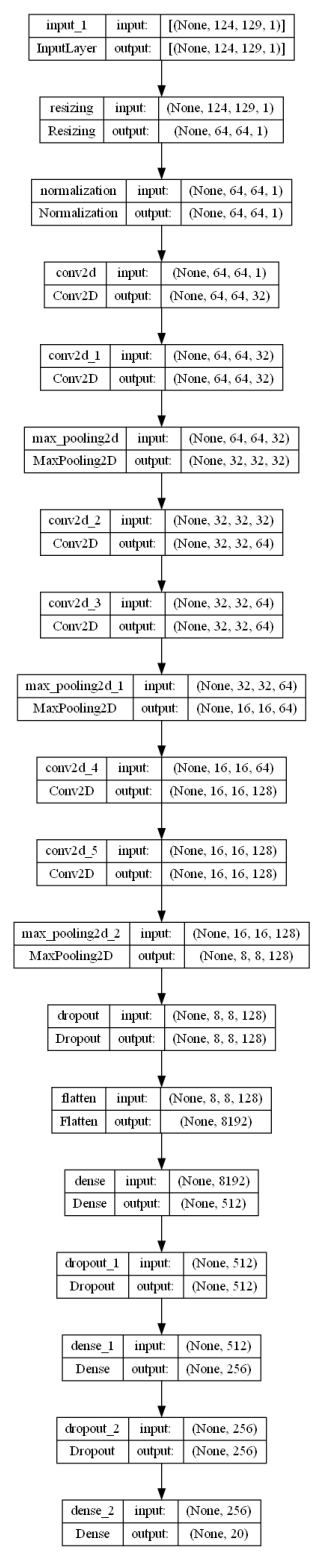

In [14]:
tf.keras.utils.plot_model(loaded_model, to_file='ASMR_CNN_Architecture.png', show_shapes=True, show_layer_names=True)

# Display the model plot
plt.figure(figsize=(15, 20))
plt.imshow(plt.imread('ASMR_CNN_Architecture.png'))
plt.axis('off')
plt.show()

## Predict Accuracy

Accuracy: 0.4756944444444444<br>
Error rate: 0.5243055555555556

In [15]:
#Predict

y_pred = loaded_model.predict(test_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)

def convert_to_label(labels):
    return [label_names[label.numpy()] for label in labels]

y_pred = convert_to_label(y_pred)
y_true = convert_to_label(tf.concat([label for _, label in test_spec_ds], axis=0))

for i, (true_label, predict_label) in enumerate(zip(y_true, y_pred)):
    print("True_label: ", true_label, "Predict_label: ", predict_label)

9/9 [==============================] - 1s 134ms/step
True_label:  gummies Predict_label:  gummies
True_label:  jelly Predict_label:  gummies
True_label:  grapes Predict_label:  grapes
True_label:  wings Predict_label:  wings
True_label:  pickles Predict_label:  ribs
True_label:  ribs Predict_label:  carrots
True_label:  gummies Predict_label:  fries
True_label:  drinks Predict_label:  drinks
True_label:  chips Predict_label:  chips
True_label:  gummies Predict_label:  pickles
True_label:  gummies Predict_label:  gummies
True_label:  jelly Predict_label:  jelly
True_label:  ribs Predict_label:  candied_fruits
True_label:  aloe Predict_label:  aloe
True_label:  pizza Predict_label:  burger
True_label:  salmon Predict_label:  gummies
True_label:  carrots Predict_label:  carrots
True_label:  chocolate Predict_label:  chocolate
True_label:  pizza Predict_label:  fries
True_label:  jelly Predict_label:  drinks
True_label:  pickles Predict_label:  pickles
True_label:  pizza Predict_label:  ca

In [16]:
correct_predictions = sum(1 for true_label, pred_label in zip(y_true, y_pred) if true_label == pred_label)
total_samples = len(y_true)
accuracy = correct_predictions / total_samples
error_rate = 1 - accuracy

print("Accuracy:", accuracy)
print("Error rate:", error_rate)

Accuracy: 0.4756944444444444
Error rate: 0.5243055555555556


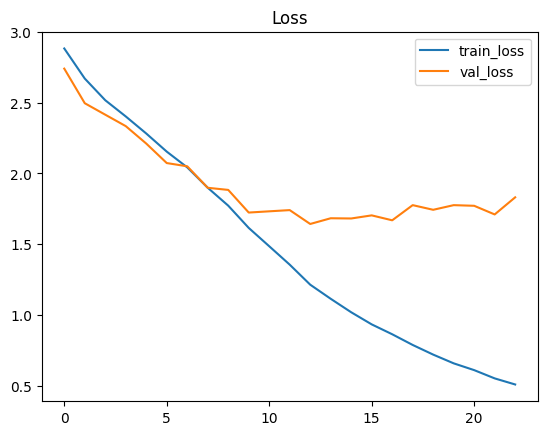

In [17]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.savefig('loss.png')
plt.show()

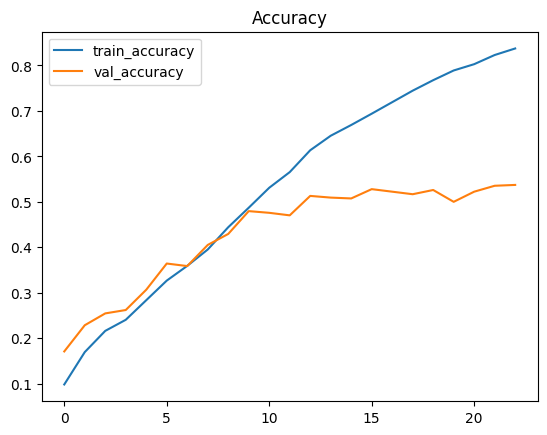

In [18]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy.png')
plt.show()

## Distribution of Predicted Ranking List

In [19]:
def predict_top_labels(model, sample):
    pred = model.predict(sample)
    top_indices = np.argsort(pred)[0][:][::-1]
    top_labels = [label_names[idx] for idx in top_indices]
    top_probabilities = [pred[0][idx] for idx in top_indices]
    return top_labels, top_probabilities

predicted_ranking_list = []
predicted_ranking_detail = []
# Sample predictions
for sample, labels in test_spec_ds:
    true_label = convert_to_label(labels)[0]
    top_labels, top_probabilities = predict_top_labels(loaded_model, sample)
    for i, (label, prob) in enumerate(zip(top_labels, top_probabilities)):
        if label == true_label:
            print(f"{true_label} / Probabilities: {prob} / Predicted Ranking: {i+1}")
            predicted_ranking_list.append(i+1)
            predicted_ranking_detail.append(f"{true_label} / Probabilities: {prob} / Predicted Ranking: {i+1}")
            break

2/2 [==============================] - 3s 9ms/step
gummies / Probabilities: 0.317137748003006 / Predicted Ranking: 1
2/2 [==============================] - 0s 54ms/step
pizza / Probabilities: 0.061271414160728455 / Predicted Ranking: 8
2/2 [==============================] - 0s 54ms/step
pizza / Probabilities: 0.13902200758457184 / Predicted Ranking: 2
2/2 [==============================] - 0s 53ms/step
ice-cream / Probabilities: 0.999927282333374 / Predicted Ranking: 1
2/2 [==============================] - 0s 54ms/step
pickles / Probabilities: 0.883147120475769 / Predicted Ranking: 1
2/2 [==============================] - 0s 56ms/step
soup / Probabilities: 0.9999291896820068 / Predicted Ranking: 1
2/2 [==============================] - 0s 54ms/step
pickles / Probabilities: 0.4445347487926483 / Predicted Ranking: 1
2/2 [==============================] - 0s 57ms/step
pizza / Probabilities: 0.05955341085791588 / Predicted Ranking: 7
2/2 [==============================] - 0s 54ms/step
jel

Accuracy: 0.4756944444444444<br>
Error rate: 0.5243055555555556

['gummies / Probabilities: 0.317137748003006 / Predicted Ranking: 1', 'pizza / Probabilities: 0.061271414160728455 / Predicted Ranking: 8', 'pizza / Probabilities: 0.13902200758457184 / Predicted Ranking: 2', 'ice-cream / Probabilities: 0.999927282333374 / Predicted Ranking: 1', 'pickles / Probabilities: 0.883147120475769 / Predicted Ranking: 1', 'soup / Probabilities: 0.9999291896820068 / Predicted Ranking: 1', 'pickles / Probabilities: 0.4445347487926483 / Predicted Ranking: 1', 'pizza / Probabilities: 0.05955341085791588 / Predicted Ranking: 7', 'jelly / Probabilities: 0.06309418380260468 / Predicted Ranking: 6']
Average predicted ranking list for all labels: 3.111111111111111


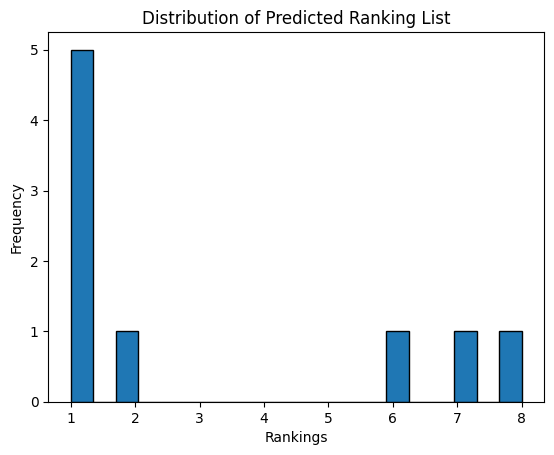

In [20]:
print(predicted_ranking_detail)

average_ranking = np.mean(predicted_ranking_list)
print(f"Average predicted ranking list for all labels: {average_ranking}")

plt.hist(predicted_ranking_list, bins=20, edgecolor='k')
plt.xlabel('Rankings')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ranking List')
plt.show()